In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

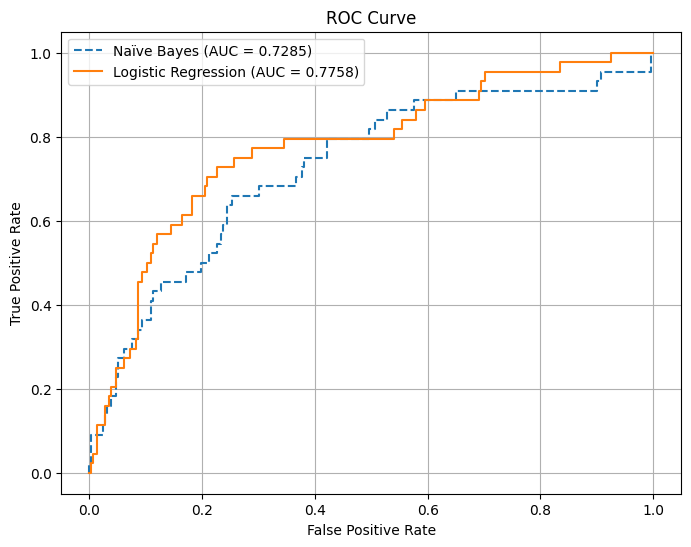

Naïve Bayes AUC: 0.7285
Logistic Regression AUC: 0.7758
Sample submission saved as sample_submission.csv


In [23]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score, roc_curve

train_path = "/kaggle/input/io-t-a-cia-1/train.csv"
test_path = "/kaggle/input/io-t-a-cia-1/test.csv"
train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

test_ids = test_df["id"]

drop_columns = ["id", "EmployeeCount", "StandardHours", "Over18"]
train_df = train_df.drop(columns=drop_columns, errors='ignore')
test_df = test_df.drop(columns=drop_columns, errors='ignore')

categorical_cols = train_df.select_dtypes(include=['object']).columns
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    train_df[col] = le.fit_transform(train_df[col])
    if col in test_df.columns:
        test_df[col] = le.transform(test_df[col])  
    label_encoders[col] = le

X = train_df.drop(columns=["Attrition"], errors='ignore')
y = train_df["Attrition"]
X_test = test_df  

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=123)

num_cols = X.select_dtypes(include=['int64', 'float64']).columns
cat_cols = X.select_dtypes(include=['object', 'category']).columns

num_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_cols),
        ('cat', cat_transformer, cat_cols)
    ]
)

nb_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', GaussianNB())
])
nb_model.fit(X_train, y_train)
nb_probs = nb_model.predict_proba(X_val)[:, 1]
nb_auc = roc_auc_score(y_val, nb_probs)

lr_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', LogisticRegression(max_iter=1000, random_state=123))
])
lr_model.fit(X_train, y_train)
lr_probs = lr_model.predict_proba(X_val)[:, 1]
lr_auc = roc_auc_score(y_val, lr_probs)

plt.figure(figsize=(8, 6))
nb_fpr, nb_tpr, _ = roc_curve(y_val, nb_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_val, lr_probs)
plt.plot(nb_fpr, nb_tpr, linestyle='--', label=f'Naïve Bayes (AUC = {nb_auc:.4f})')
plt.plot(lr_fpr, lr_tpr, linestyle='-', label=f'Logistic Regression (AUC = {lr_auc:.4f})')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid()
plt.show()

print(f"Naïve Bayes AUC: {nb_auc:.4f}")
print(f"Logistic Regression AUC: {lr_auc:.4f}")

nb_test_probs = nb_model.predict_proba(X_test)[:, 1]
lr_test_probs = lr_model.predict_proba(X_test)[:, 1]

submission = pd.DataFrame({
    "id": test_ids,
    "Attrition": lr_test_probs  
})
submission.to_csv("sample_submission.csv", index=False)

print("Sample submission saved as sample_submission.csv")
